### 1 Problem

How well can we predict the closing price of a stock every day? Let's use `TSLA` as an example

#### Outcomes
- Timeseries analysis
- Novel method of evaluation of model
- Machine Learning isn't magic

### 2 Get Stock Market Data

Data For the stock market can be downloaded from here: https://finance.yahoo.com/. Recommended to download this instead of using the provided CSV for the most recent data

In [2]:
#!pip3 install pytrends

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper

# Additional Features
from pytrends.request import TrendReq
from utils import get_daily_trend

In [2]:
tesla = pd.read_csv('data/TSLA.csv')
tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [3]:
def get_stats(df):
    start_date = datetime.datetime.strptime(df['Date'].min(), '%Y-%m-%d')
    end_date = datetime.datetime.strptime(df['Date'].max(), '%Y-%m-%d')
    data_duration = (end_date - start_date).days

    print(f"Start Date: {df['Date'].min()}")
    print(f"End Date: {df['Date'].max()}")
    print(f"Date Difference: {data_duration}")
    print(f"Number of Data Points: {df.shape[0]}")

In [4]:
get_stats(tesla)

Start Date: 2010-06-29
End Date: 2021-07-16
Date Difference: 4035
Number of Data Points: 2782


Let's plot the adjusted closed price for the last 50 days 

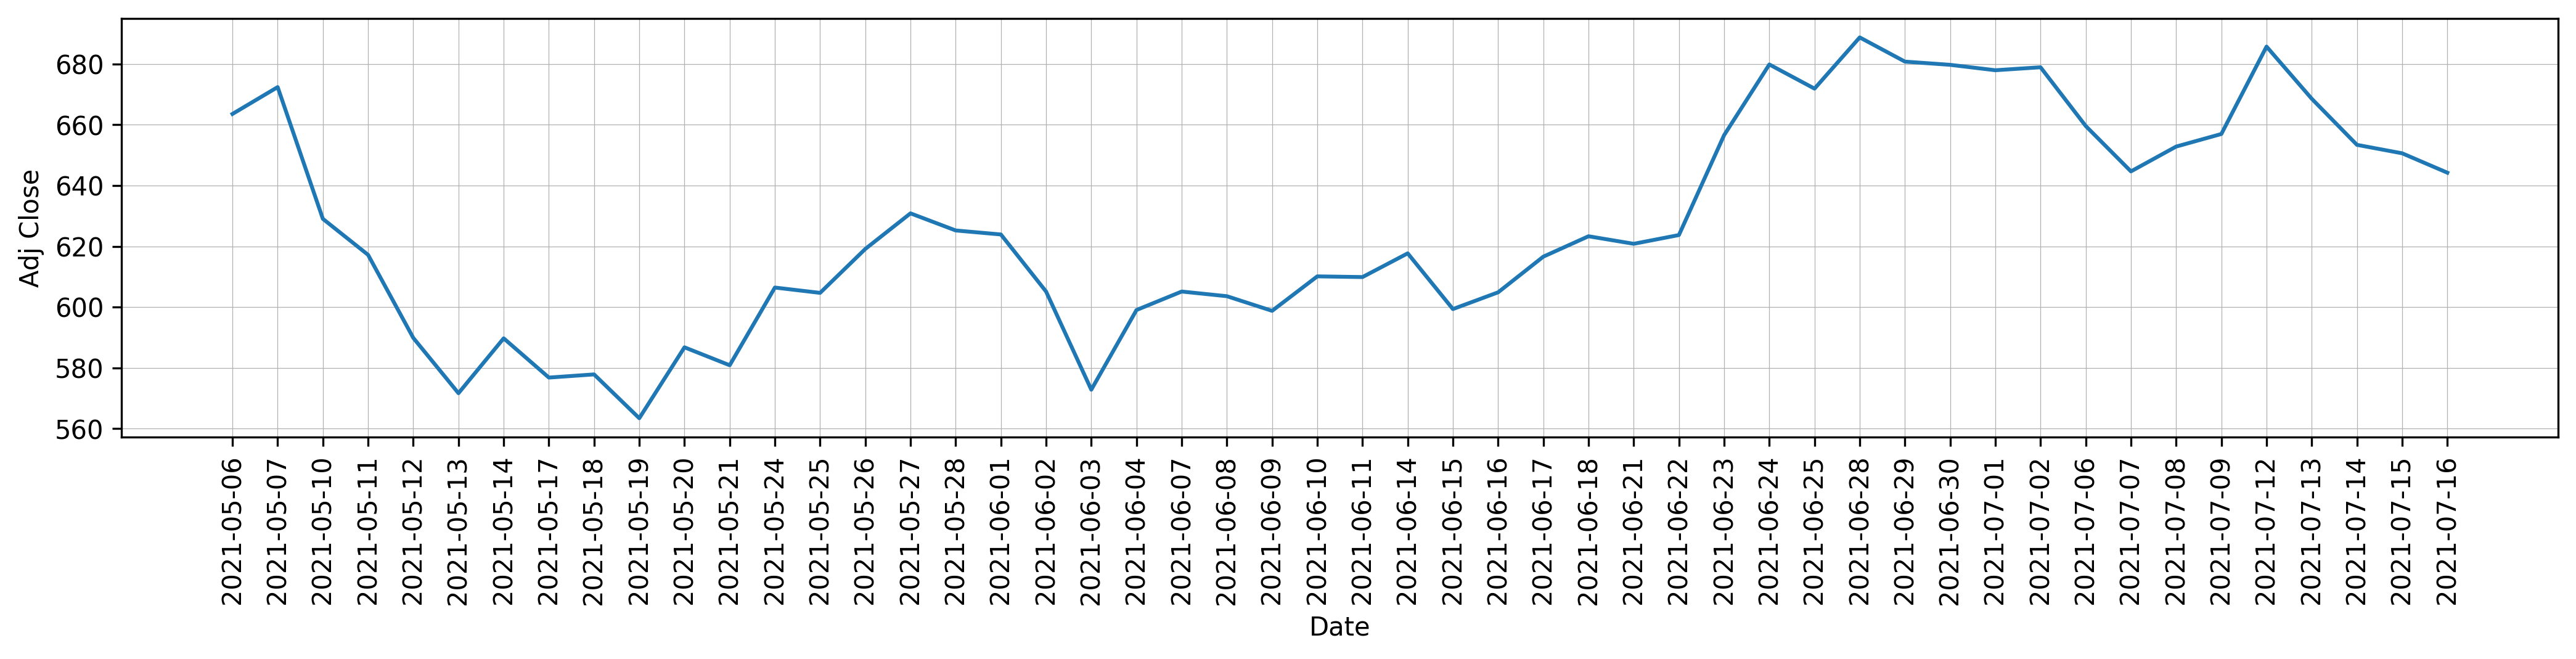

In [5]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=tesla.tail(50), x='Date', y='Adj Close')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

### 3  Feature Engineering

Let's see how far we can get with:
1. Lagged Ajusted Close price
2. Previous day's volume
3. Day of week

In [3]:
tesla.columns = ['date', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume']
tesla['prev_adjusted_close'] = tesla['adjusted_close'].shift(1)
tesla['prev_volume'] = tesla['volume'].shift(1)
tesla['day_of_week'] = pd.to_datetime(tesla['date']).dt.dayofweek
data = tesla[['date', 'adjusted_close', 'prev_adjusted_close', 'prev_volume', 'day_of_week']].dropna()
data.sample()

,date,adjusted_close,prev_adjusted_close,prev_volume,day_of_week
2017,2018-07-03,62.172001,67.014,93799000.0,1


In [7]:
categorical_features = ['day_of_week']
numerical_features = ['prev_adjusted_close', 'prev_volume']
label = 'adjusted_close'

train_df, test_df = train_test_split(data, test_size=0.1, shuffle=False)
X_train, y_train = train_df[categorical_features + numerical_features], train_df[label]
X_test, y_test = test_df[categorical_features + numerical_features], test_df[label]

num = [([n], [StandardScaler()]) for n in numerical_features]
cat = [([n], [OrdinalEncoder()]) for n in categorical_features]
mapper = DataFrameMapper(num + cat, df_out=True)

preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)
results = sm.OLS(y_train, preprocessed_X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         adjusted_close   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.733e+05
Date:                Mon, 19 Jul 2021   Prob (F-statistic):               0.00
Time:                        00:18:28   Log-Likelihood:                -5438.8
No. Observations:                2502   AIC:                         1.089e+04
Df Residuals:                    2498   BIC:                         1.091e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  41.1359      0.075    549.627      0.000      40.989      41.283
prev_adjusted_close    30.6598      0.052    586.320      0.000      30.557      30.762
prev_volume             0.0467      0.052      0.892      0.372      -0.056       0.149
day_of_week            -0.0918      0.030     -3.019      0.003      -0.151      -0.032
==============================================================================
Omnibus:                     1014.937   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           262833.236
Skew:                          -0.683   Prob(JB):                         0.00
Kurtosis:                      53.193   Cond. No.                         4.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's leave in `prev_volume`. If taken alone, it shows significance. The linear regression model may not be complex enough to capture contribution by `prev_volume`

### 4 Model Training

In [4]:
def evaluation(pipeline, X, y):
    y_prediction = pipeline.predict(X)
    return{
        'MAE': mean_absolute_error(y, y_prediction),
        'MAPE': mean_absolute_percentage_error(y, y_prediction),
        'y_pred': y_prediction
    }

In [12]:
mapper = DataFrameMapper(num + cat, df_out=True)
clf = LinearRegression()
pipeline = Pipeline([
    ('preprocess', mapper),
    ('clf', clf)
])

pipeline.fit(X_train, y_train)
results = evaluation(pipeline, X_test, y_test)
print(f"MAE: ${round(results['MAE'], 2)}, MAPE: {round(results['MAPE'] * 100, 2)}%")

MAE: $16.72, MAPE: 3.19%


Simple Linear Regression looks like it's doing super well. But is it?

In [17]:
tesla_forecast = pd.DataFrame(data={
    'date': test_df['date'].reset_index().drop('index', axis=1)['date'],
    'predictions': results['y_pred'],
    'truth': y_test.reset_index().drop('index', axis=1)['adjusted_close']})
tesla_forecast.sample()

,date,predictions,truth
69,2020-09-16,450.418517,441.76001


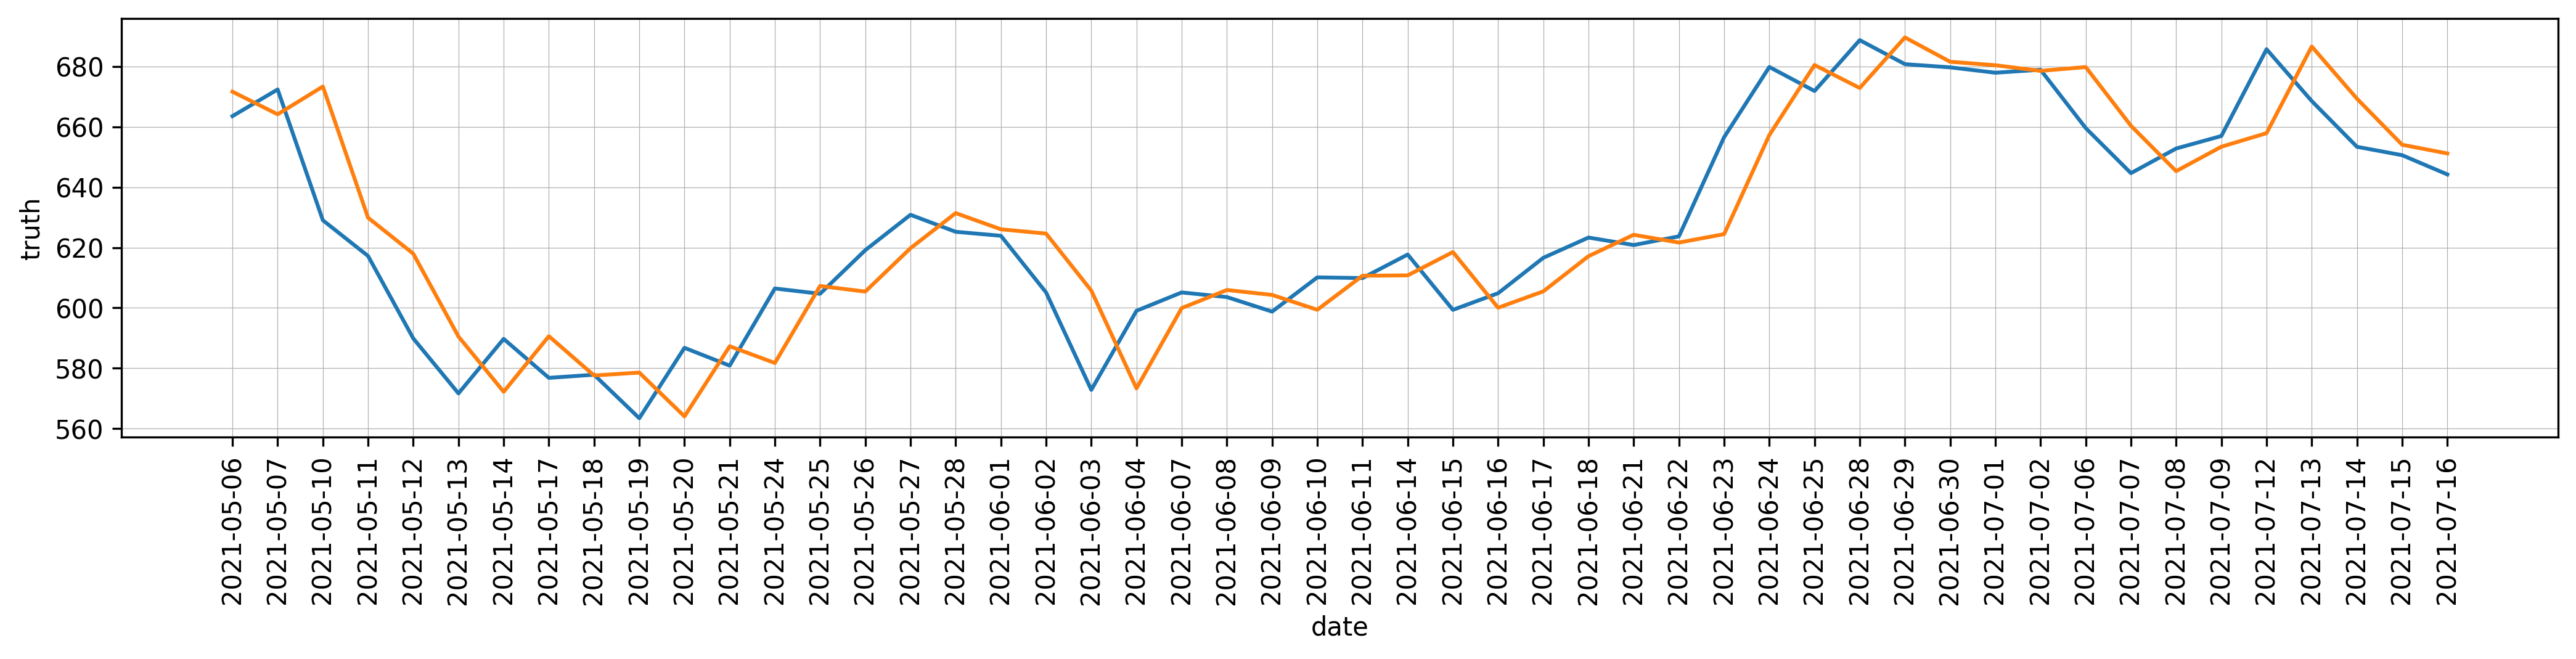

In [15]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=tesla_forecast.tail(50), x='date', y='truth')
sns.lineplot(data=tesla_forecast.tail(50), x='date', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [16]:
tesla_forecast.tail(10)

,date,predictions,truth
269,2021-07-02,678.526972,678.900024
270,2021-07-06,679.797402,659.580017
271,2021-07-07,660.357144,644.650024
272,2021-07-08,645.310753,652.809998
273,2021-07-09,653.394961,656.950012
274,2021-07-12,657.899066,685.700012
275,2021-07-13,686.603344,668.539978
276,2021-07-14,669.323372,653.380005
277,2021-07-15,654.055508,650.599976
278,2021-07-16,651.178141,644.219971


Not a good evaluation metric since we are lagging the truth. Maybe it's more apparent in drops

### 5 Better Evaluation Metric

In [18]:
test_df['perc_change'] = (
    (test_df['adjusted_close'] - test_df['prev_adjusted_close']) * 100 / \
    test_df['prev_adjusted_close']).abs()
tesla_forecast = tesla_forecast.merge(test_df[['date', 'perc_change']], on='date')
tesla_forecast.sample()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,predictions,truth,perc_change
140,2020-12-28,662.732498,663.690002,0.290128


In [19]:
performance = []
for perc_change in np.arange(0, 10, 0.5):
    test = tesla_forecast[tesla_forecast['perc_change'] > perc_change]
    performance.append({
        'perc_change': perc_change,
        'MAE':  mean_absolute_error(test['truth'], test['predictions']),
        'MAPE':  mean_absolute_percentage_error(test['truth'], test['predictions']),
        'count': test.shape[0]
    })
results = pd.DataFrame(performance)

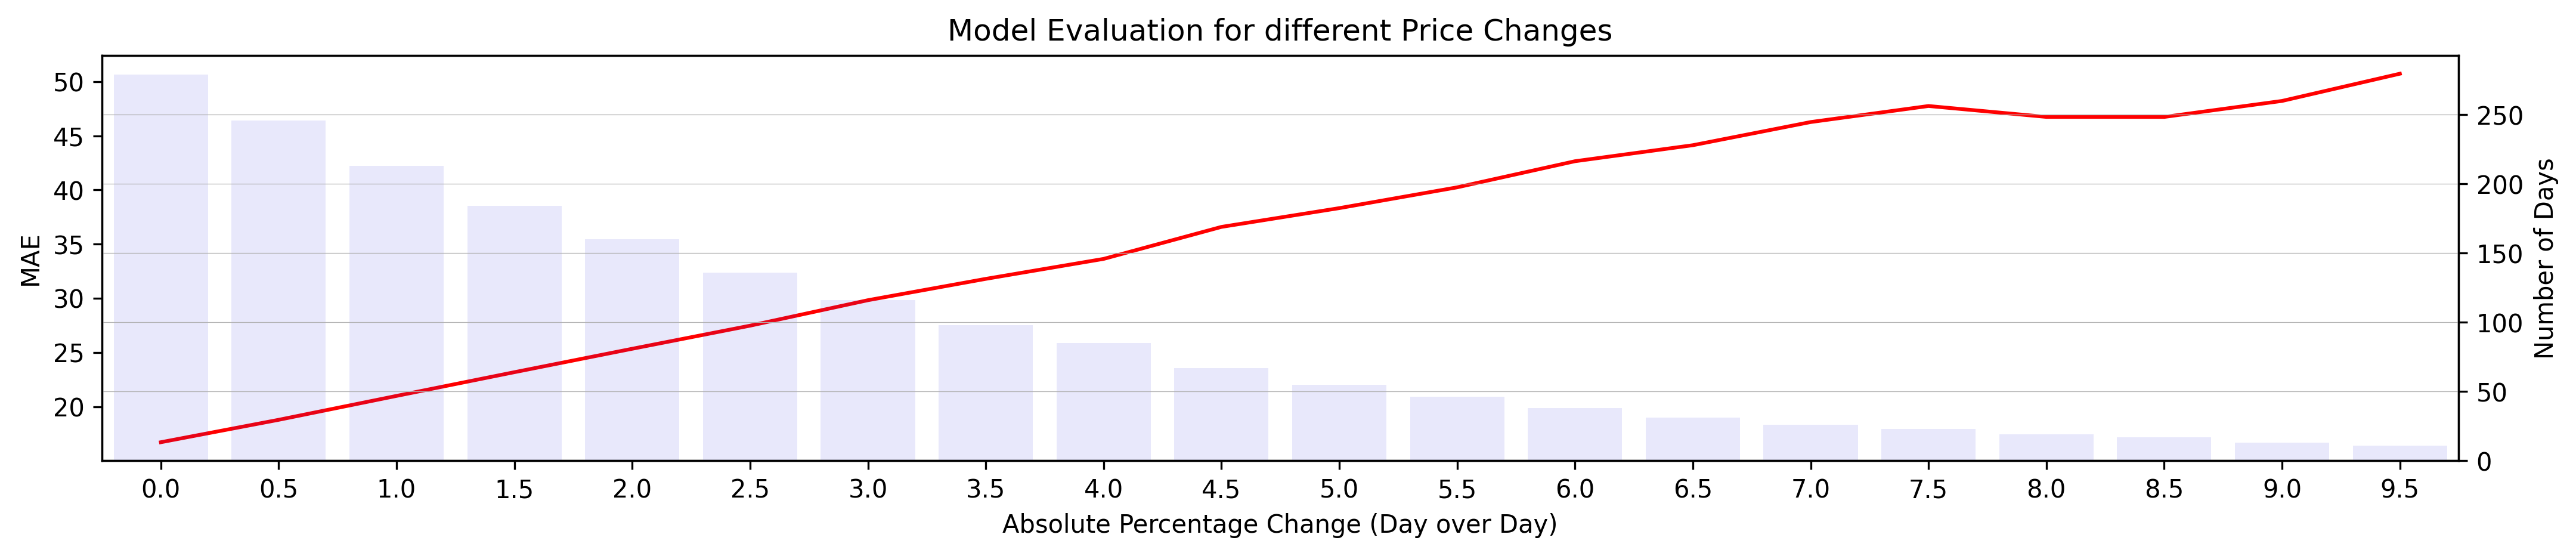

In [21]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
fig, ax = plt.subplots()
ax2 = ax.twinx()

sns.lineplot(
    data=results['MAE'],
    color='red',
    legend=True,
    ax=ax)

sns.barplot(
    x='perc_change',
    y='count',
    data=results,
    color='blue',
    alpha=0.1,
    ax=ax2
)

plt.grid(linestyle='-', linewidth=0.3)
title = ax.set_title('Model Evaluation for different Price Changes')
xlabel = ax.set_xlabel('Absolute Percentage Change (Day over Day)')
ylabel = ax2.set_ylabel('Number of Days')
y2label = ax.set_ylabel('MAE')

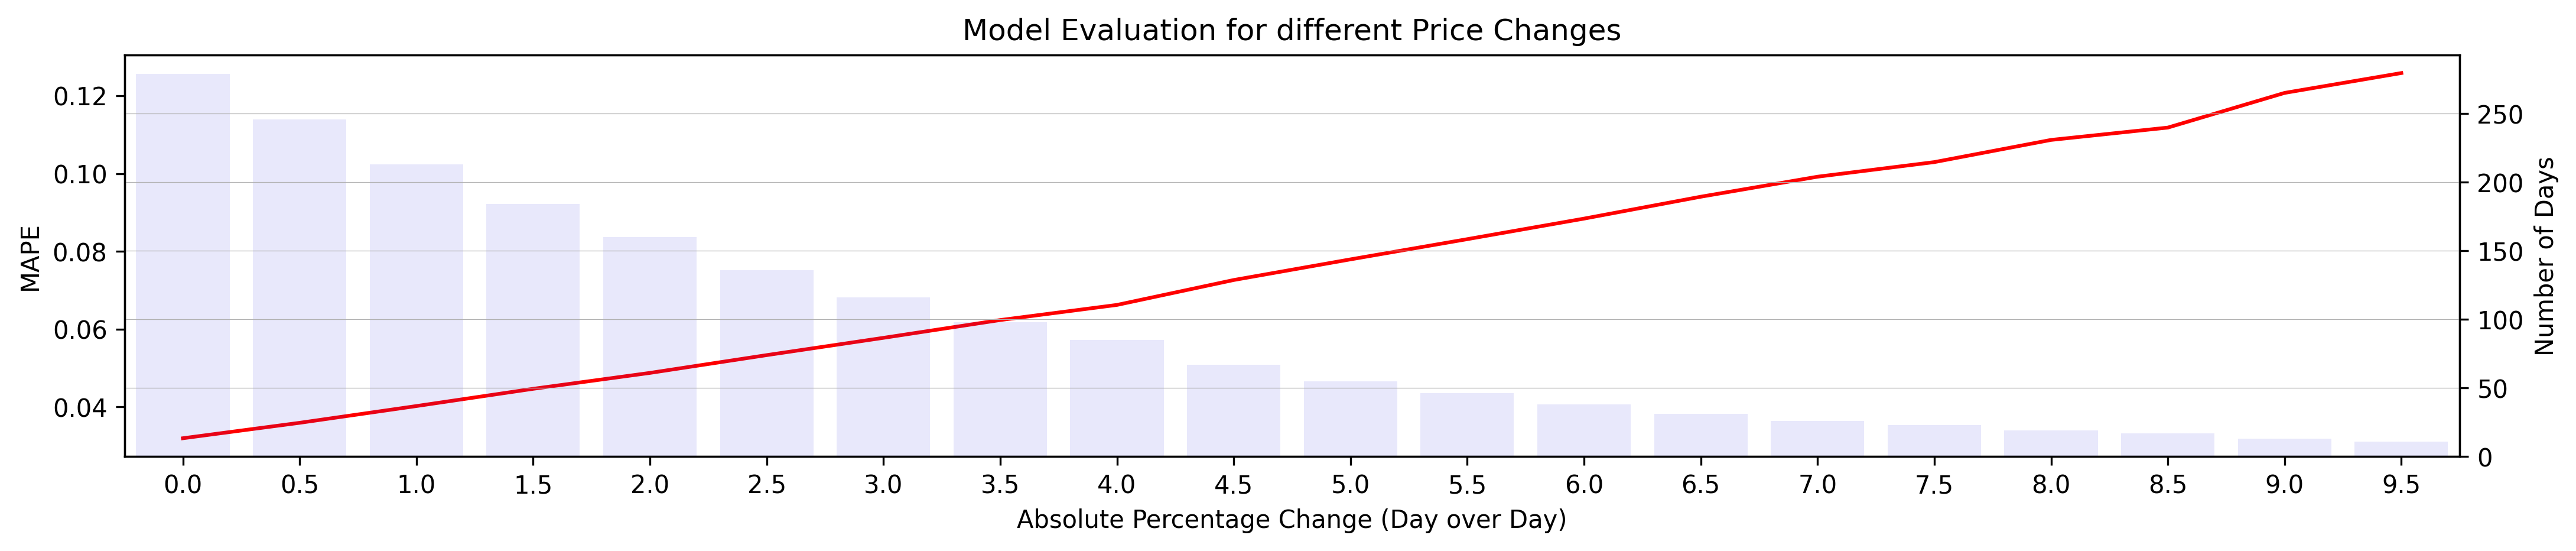

In [22]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
fig, ax = plt.subplots()
ax2 = ax.twinx()

sns.lineplot(
    data=results['MAPE'],
    color='red',
    legend=True,
    ax=ax)

sns.barplot(
    x='perc_change',
    y='count',
    data=results,
    color='blue',
    alpha=0.1,
    ax=ax2
)

plt.grid(linestyle='-', linewidth=0.3)
title = ax.set_title('Model Evaluation for different Price Changes')
xlabel = ax.set_xlabel('Absolute Percentage Change (Day over Day)')
ylabel = ax2.set_ylabel('Number of Days')
y2label = ax.set_ylabel('MAPE')

### 6 Model Improvement: Adding Google Trend Data

In [5]:
pytrend = TrendReq(hl='en-US')
keyword = 'tesla'
start = tesla['date'].min()
end = tesla['date'].max()

trends = get_daily_trend(pytrend, keyword, start=start, end=end)
trends_df = trends.reset_index().drop('overlap', axis=1)
trends_df.columns=['date', 'trend_score']
trends_df['date'] = trends_df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
data = data.merge(trends_df, on='date')
data.sample()

,date,adjusted_close,prev_adjusted_close,prev_volume,day_of_week,trend_score
313,2011-09-26,5.104,5.276,5782000.0,0,2.0


In [28]:
categorical_features = []
numerical_features = ['trend_score']
label = 'adjusted_close'

train_df, test_df = train_test_split(data, test_size=0.1, shuffle=False)
X_train, y_train = train_df[categorical_features + numerical_features], train_df[label]
X_test, y_test = test_df[categorical_features + numerical_features], test_df[label]

num = [([n], [StandardScaler()]) for n in numerical_features]
cat = [([n], [OrdinalEncoder()]) for n in categorical_features]
mapper = DataFrameMapper(num + cat, df_out=True)

preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)
results = sm.OLS(y_train, preprocessed_X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         adjusted_close   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     1609.
Date:                Mon, 19 Jul 2021   Prob (F-statistic):          4.30e-272
Time:                        00:27:16   Log-Likelihood:                -11501.
No. Observations:                2502   AIC:                         2.301e+04
Df Residuals:                    2500   BIC:                         2.302e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          40.9501      0.480     85.337      0.000      40.009      41.891
trend_score    19.2497      0.480     40.115      0.000      18.309      20.191
==============================================================================
Omnibus:                     1391.000   Durbin-Watson:                   0.326
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           219326.384
Skew:                          -1.577   Prob(JB):                         0.00
Kurtosis:                      48.759   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Adding this into the LinearRegression model doesn't improve performance tho. 

### 7 Things to Try

- Introduce a more complex model to pick up on more complex patterns
- Add other predictors you think would be indicitive of stock prices
    - Perhaps you want to use more than 1 day of data in the features
- Reduce the timeframe of training and see how effective say 1 month's of data is (instead of the over 5 years worth we are using)

Here is a lil template

In [6]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Perceptron

In [20]:
categorical_features = ['day_of_week']
numerical_features = ['prev_adjusted_close', 'prev_volume', 'trend_score']
label = 'adjusted_close'

train_df, test_df = train_test_split(data, test_size=0.1, shuffle=False)
X_train, y_train = train_df[categorical_features + numerical_features], train_df[label]
X_test, y_test = test_df[categorical_features + numerical_features], test_df[label]

num = [([n], [SimpleImputer()]) for n in numerical_features]
cat = [([c], [SimpleImputer(), OrdinalEncoder()]) for c in categorical_features]
mapper = DataFrameMapper(num + cat, df_out=True)

##########################################
#   Insert more complex model here!      #
##########################################

pipeline = Pipeline([
    ('preprocess', mapper),
    ('model', model)
])

pipeline.fit(X_train, y_train)
results = evaluation(pipeline, X_test, y_test)
print(f"MAE: ${round(results['MAE'], 2)}, MAPE: {round(results['MAPE'] * 100, 2)}%")

In [21]:
evaluation(pipeline, X_train, y_train)

In [22]:
tesla_forecast = pd.DataFrame(data={
    'date': test_df['date'].reset_index().drop('index', axis=1)['date'],
    'predictions': results['y_pred'],
    'truth': y_test.reset_index().drop('index', axis=1)['adjusted_close']})

test_df['perc_change'] = ((test_df['adjusted_close'] - test_df['prev_adjusted_close']) * 100 / \
    test_df['prev_adjusted_close']).abs()
tesla_forecast = tesla_forecast.merge(test_df[['date', 'perc_change']], on='date')

performance = []
for perc_change in np.arange(0, 10, 0.5):
    test = tesla_forecast[tesla_forecast['perc_change'] > perc_change]
    performance.append({
        'perc_change': perc_change,
        'MAE':  mean_absolute_error(test['truth'], test['predictions']),
        'MAPE':  mean_absolute_percentage_error(test['truth'], test['predictions']),
        'count': test.shape[0]
    })
results = pd.DataFrame(performance)

Cool Blog post for trend data daily: https://towardsdatascience.com/reconstruct-google-trends-daily-data-for-extended-period-75b6ca1d3420